In [ ]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import copy
import tqdm
from PIL import Image
 
import albumentations
from albumentations import pytorch as AT
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import time
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import torch.nn.functional as F
import copy
import tqdm
import time
from PIL import Image
 
import albumentations
from albumentations import pytorch as AT

In [ ]:
!pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
import random

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

In [ ]:
# from albumentations.pytorch import ToTensorV2 as tt

In [ ]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append('/content/drive/My Drive/Kaggle_Korpus')

from implementation import *

In [ ]:
!ls

drive  preds.csv  sample_data


In [ ]:
!nvidia-smi

Fri Sep  4 17:35:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# with zipfile.ZipFile('/content/drive/My Drive/dogs-vs-cats.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content')
  
# with zipfile.ZipFile('/content/train.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content/dataset')

# with zipfile.ZipFile('/content/test1.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content/dataset')

In [ ]:
# train_dir = '/content/dataset/train'
# # test_dir = '/content/dataset/test1'
# # train_files = os.listdir(train_dir)
# train_files = 
# test_files = os.listdir(test_dir)


In [ ]:
from os import walk
files_dirs = os.listdir('/content/drive/My Drive/updated')
print(files_dirs)
f = []
for dir in files_dirs:
    for (dirpath, dirnames, filenames) in walk(os.path.join('/content/drive/My Drive/updated', dir)):
        # if 'just_image' not in dir:
        f.extend(filenames[:1000])
        break
label_to_name = {1 : 'bar_chart', 2 : 'diagram', 3 : 'flow_chart',
                              4 : 'graph', 5 : 'growth_chart', 6 : 'pie_chart',
                              7 : 'table', 0 : 'just_image'}
name_to_label = {'bar_chart' : 1, 'diagram' : 2, 'flow_chart' : 3,
                              'graph' : 4, 'growth_chart' : 5, 'pie_chart' : 6,
                              'table' : 7, 'just_image' : 0}
path_dict = dict()
for dir in files_dirs:
    for key in name_to_label:
        if key in dir:
            path_dict[key] = dir
            break
        
train_files = f.copy()
len(train_files)

['resized_just_image', 'resized_table_dataset_cleared', 'bar_chart_resized', 'resized_diagram_dataset', 'resized_flow_chart_dataset', 'resized_graph', 'resized_pie_chart', 'resized_growth_chart']


8000

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_dir = '/content/drive/My Drive/updated'
test_dir = '/content/drive/My Drive/Kaggle_Korpus/test/test'

In [ ]:
# train_files = os.listdir(train_dir)
# test_files = os.listdir(test_dir)

In [ ]:
def split_train_set(files_list: list, valid_size=0.15):
    valid_size = int(len(train_files) * 0.15)
    indices = torch.randperm(len(train_files))
    train_indices = indices[:len(indices) - valid_size]
    valid_indices = indices[len(indices) - valid_size:]
    train_list = [files_list[i] for i in train_indices]
    val_list = [files_list[i] for i in valid_indices]
    return train_list, val_list

In [ ]:
class RecognitionDataset(Dataset):
    def __init__(self, file_list, dir, transform=None, mode='train', image_size=224, path_dict=None):
        self.path_dict = path_dict
        self.file_list = file_list
        self.dir = dir
        self.transform = transform
        self.mode = mode
        self.label = 0
        self.name_to_label = {'bar_chart' : 1, 'diagram' : 2, 'flow_chart' : 3,
                              'graph' : 4, 'growth_chart' : 5, 'pie_chart' : 6,
                              'table' : 7, 'just_image' : 0}
        self.label_to_name = {1 : 'bar_chart', 2 : 'diagram', 3 : 'flow_chart',
                              4 : 'graph', 5 : 'growth_chart', 6 : 'pie_chart',
                              7 : 'table', 0 : 'just_image'}
        # self.name_to_label = {'bar_chart' : 0, 'diagram' : 1, 'flow_chart' : 2,
        #                       'graph' : 3, 'growth_chart' : 4, 'pie_chart' : 5,
        #                       'table' : 6, 'just_image' : 7}
        # self.label_to_name = {0 : 'bar_chart', 1 : 'diagram', 2 : 'flow_chart',
        #                       3 : 'graph', 4 : 'growth_chart', 5 : 'pie_chart',
        #                       6 : 'table', 7 : 'just_image'}
    def __len__(self):
        return len(self.file_list)

    
    def __getitem__(self, idx):
        cur_dir = self.dir
        if self.mode in ['train', 'val']:
            for key in self.name_to_label:
                if key in self.file_list[idx]:
                    cur_dir = os.path.join(self.dir, self.path_dict[key])
                    self.label = self.name_to_label[key]
                    break
        else:
            cur_dir = self.dir
        # print(cur_dir)
        image = cv2.imread(os.path.join(cur_dir, self.file_list[idx]))
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            # print(os.path.join(cur_dir, self.file_list[idx]))
            img = Image.open(os.path.join(cur_dir, self.file_list[idx]))
            for frame in ImageSequence.Iterator(img):
                image = cv2.cvtColor(np.asarray(frame), cv2.COLOR_RGB2BGR)
                # frame1 = scale(imcv, 224)
                # frame1.save(new_file_path)
                # print(frame1)
                # print(type(frame1), frame1.shape, len(frame1))
                # cv2.imwrite(new_file_path, frame1)
                break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # if self.mode == 'train':
        #     for key in self.name_to_label:
        #         if key in self.file_list[idx]:
        #             self.label = self.name_to_label[key]
        #             break
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        if self.mode in ['train', 'val']:
            return image, self.label
        else:
            return image


In [ ]:
from PIL import Image, ImageSequence
class RecognitionDatasetTest(Dataset):
    def __init__(self, file_list, dir, transform=None, mode='train', image_size=224, path_dict=None):
        self.path_dict = path_dict
        self.file_list = file_list
        self.dir = dir
        self.transform = transform
        self.mode = mode
        self.label = 0
        self.name_to_label = {'bar_chart' : 1, 'diagram' : 2, 'flow_chart' : 3,
                              'graph' : 4, 'growth_chart' : 5, 'pie_chart' : 6,
                              'table' : 7, 'just_image' : 0}
        self.label_to_name = {1 : 'bar_chart', 2 : 'diagram', 3 : 'flow_chart',
                              4 : 'graph', 5 : 'growth_chart', 6 : 'pie_chart',
                              7 : 'table', 0 : 'just_image'}
        # self.name_to_label = {'bar_chart' : 0, 'diagram' : 1, 'flow_chart' : 2,
        #                       'graph' : 3, 'growth_chart' : 4, 'pie_chart' : 5,
        #                       'table' : 6, 'just_image' : 7}
        # self.label_to_name = {0 : 'bar_chart', 1 : 'diagram', 2 : 'flow_chart',
        #                       3 : 'graph', 4 : 'growth_chart', 5 : 'pie_chart',
        #                       6 : 'table', 7 : 'just_image'}
        
    def __len__(self):
        return len(self.file_list)

    
    def __getitem__(self, idx):
        cur_dir = self.dir
        if self.mode in ['train', 'val']:
            for key in self.name_to_label:
                if key in self.file_list[idx]:
                    cur_dir = os.path.join(self.dir, self.path_dict[key])
                    self.label = self.name_to_label[key]
                    break
        else:
            cur_dir = self.dir
        # print(cur_dir)
        image = cv2.imread(os.path.join(cur_dir, self.file_list[idx]))
        try:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            # print(os.path.join(cur_dir, self.file_list[idx]))
            img = Image.open(os.path.join(cur_dir, self.file_list[idx]))
            for frame in ImageSequence.Iterator(img):
                image = cv2.cvtColor(np.asarray(frame), cv2.COLOR_RGB2BGR)
                # frame1 = scale(imcv, 224)
                # frame1.save(new_file_path)
                # print(frame1)
                # print(type(frame1), frame1.shape, len(frame1))
                # cv2.imwrite(new_file_path, frame1)
                break

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # if self.mode == 'train':
        #     for key in self.name_to_label:
        #         if key in self.file_list[idx]:
        #             self.label = self.name_to_label[key]
        #             break
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        if self.mode in ['train', 'val']:
            return image, self.label
        else:
            return image


In [ ]:
batch_size = 32
num_workers = 0
img_size = 224


In [ ]:
train_list, val_list = split_train_set(train_files)

In [ ]:
data_transform = {
    'val': albumentations.Compose([
        # albumentations.Resize(img_size, img_size),
        # # albumentations.Normalize(),
        # albumentations.Normalize(mean=([0.6, 0.6, 0.6])),
        # AT.ToTensor()
        albumentations.Resize(img_size, img_size),
        # albumentations.ToGray(p=1),
        albumentations.Normalize(mean=(0.80, 0.80, 0.80), std=(0.19, 0.19, 0.19)),
        AT.ToTensor()
        ]),
    'train': albumentations.Compose([
        albumentations.Resize(img_size, img_size),
    # albumentations.Resize(img_size, img_size),
    albumentations.HorizontalFlip(0.5),
    albumentations.VerticalFlip(),
    # albumentations.RandomBrightness(limit=0.1),
    albumentations.ShiftScaleRotate(rotate_limit=5, scale_limit=0.10),
    # albumentations.HueSaturationValue(0.1),
    #     # albumentations.Transpose(),
    # albumentations.CLAHE(),
    # albumentations.Blur(p=0.1),
    #     albumentations.Normalize(mean=([0.6, 0.6, 0.6])),
        # AT.ToTensor(),
        # albumentations.RandomBrightness(),
        # albumentations.ToGray(p=1),
        # albumentations.ShiftScaleRotate(),
        # albumentations.Normalize(mean=(0.5, 0.5, 0.5), std=(0.235, 0.235, 0.235)),
        albumentations.Normalize(mean=(0.80, 0.80, 0.80), std=(0.19, 0.19, 0.19)),
        AT.ToTensor()
        
        ]),
    'test': albumentations.Compose([
        # albumentations.Resize(img_size, img_size),
        # # albumentations.Normalize(),
        # albumentations.Normalize(mean=([0.6, 0.6, 0.6])),
        # AT.ToTensor()
        albumentations.Resize(img_size, img_size),
        # albumentations.ToGray(p=1),
        albumentations.Normalize(mean=(0.75, 0.75, 0.75), std=(0.21, 0.21, 0.21)),
        AT.ToTensor()
        ])
}

In [ ]:
trainset = RecognitionDataset(train_list, train_dir, transform=data_transform['train'], path_dict=path_dict)
valset = RecognitionDataset(val_list, train_dir, transform=data_transform['val'], path_dict=path_dict)
# testset = RecognitionDataset(test_files, test_dir, transform=data_transform['test'])
print(len(trainset) + len(valset))

8000


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                        batch_size=batch_size,
                                        shuffle=True
                                        )
validloader = torch.utils.data.DataLoader(valset, 
                                        batch_size=batch_size,
                                        
                                        )

# testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
#                                          num_workers = num_workers)
for_norm = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


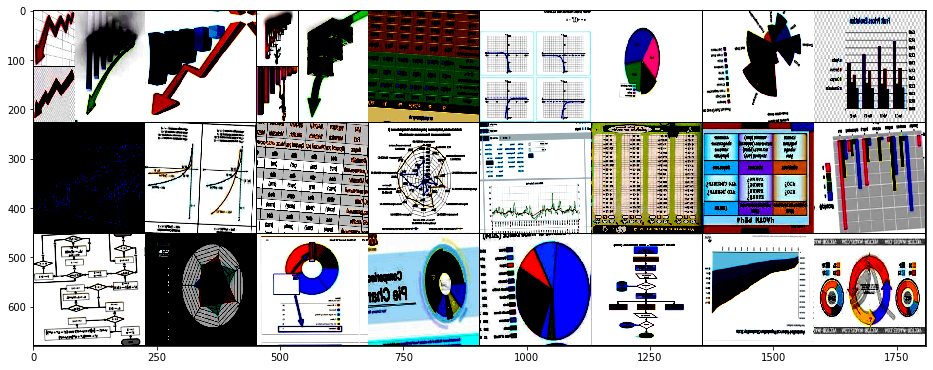

In [ ]:
samples, labels = next(iter(trainloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')
for_norm.extend(samples)
print(len(for_norm))

In [ ]:
# for_norm = []
# stanR = 0
# stanG = 0
# stanB = 0
# meanR = 0
# meanG = 0
# meanB = 0

# for i, (sample, label) in enumerate(trainloader):
#     if i >= 30:
#         break
#     for s in sample:
#         stanR += s[:, :, 0].std()
#         stanG += s[:, :, 1].std()
#         stanB += s[:, :, 2].std()
#         meanR += s[:, :, 0].mean()
#         meanG += s[:, :, 1].mean()
#         meanB += s[:, :, 2].mean()
# meanR /= 30*32
# meanG /= 30*32
# meanB /= 30*32
# stanR /= 30*32
# stanG /= 30*32
# stanB /= 30*32


In [ ]:
# print(meanR, meanG, meanB, stanR, stanG, stanB)

In [ ]:
# for_norm[0][:, :, 0].std()

In [ ]:
# t = 0
# for i, (data, target) in enumerate(trainloader):
#     t += 1
#     if t % 10 == 0:
#         print(t)

In [ ]:
class ResBlock(nn.Module):
    expansion = 1
    def __init__(self, inchannels, outchannels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(outchannels)
        )
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=outchannels, out_channels=outchannels, kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(outchannels)
        )
        self.skip = nn.Sequential()
        if stride != 1 or outchannels * self.expansion != inchannels:
            self.skip = nn.Sequential(nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=3, stride=stride, padding=1, bias=False),
                                   nn.BatchNorm2d(outchannels * self.expansion)
            )

    
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.skip(x)
        out = F.relu(out)
        return out

class MyResNet(nn.Module):
    def __init__(self, block, num_classes, inchannels):
        super(MyResNet, self).__init__()
        self.inchannels = 64
        self.conv1 = self.conv1 = nn.Sequential(nn.Conv2d(in_channels=inchannels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
                                   nn.BatchNorm2d(64)
        )
        self.block1 = self.make_layer(ResBlock, 64, 2, 1)
        self.block2 = self.make_layer(ResBlock, 128, 2, 2)
        self.block3 = self.make_layer(ResBlock, 256, 2, 2)
        self.block4 = self.make_layer(ResBlock, 512, 2, 2)
        self.fc = nn.Linear(block.expansion * 512, num_classes)


    def make_layer(self, block, outchannels, num_blocks, first_stride):
        strides = [first_stride] + [1] * (num_blocks - 1)
        layers = []
        for cur_stride in strides:
            layers.append(block(self.inchannels, outchannels, cur_stride))
            self.inchannels = block.expansion * outchannels
        return nn.Sequential(*layers)
    

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = F.avg_pool2d(out, out.size()[3])
        #out = torch.flatten(out,1 )
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# lr = 0.001
# n_epoch = 10

# # model = ConvNet2().to(device)
# # model = Model(ResidualBlock=ResidualBlock, num_classes=10).to(device)
# # model = resnet34.to(device)
# # model = MyResNet(ResBlock, 10, 3).to(device)
# model = MyResNet(ResBlock, 8, 3).to(device)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss()
# # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=n_epoch, 
#                                                 steps_per_epoch=len(trainloader))
# # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
# # scheduler = optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=0.001, max_lr=0.01)

In [ ]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, n_epochs, scheduler):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 5
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False
    model.train()
    # количество эпох
    for epoch in range(1, n_epochs+1):
        # torch.cuda.empty_cache()
        model.train()
        print(time.ctime(), 'Epoch:', epoch)

        train_loss = []

        for batch_i, (data, target) in enumerate(train_loader):

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model_conv(data)
            loss = criterion(output, target)
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
    # запускаем валидацию
        with torch.no_grad():
            model_conv.eval()
            val_loss = []
            cur_acc = 0
            for batch_i, (data, target) in enumerate(valid_loader):
                data, target = data.to(device), target.to(device)
                output = model_conv(data)
                loss = criterion(output, target)
                val_loss.append(loss.item()) 
                cur_acc += (torch.max(output.data, 1)[1] == target.data).sum().item() #target.data ?
                # scheduler.step() #onecycle
            print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, current accuracy: {cur_acc / len(valid_loader)}')

            valid_loss = np.mean(val_loss)
            scheduler.step(valid_loss) #reduceOnPlateou
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
                torch.save(model_conv.state_dict(), '/content/drive/My Drive/night_submit/model_eff_dict.pt')
                valid_loss_min = valid_loss
                p = 0

            # проверяем как дела на валидации
        if valid_loss > valid_loss_min:
            p += 1
            print(f'{p} epochs of increasing val loss')
            if p > patience:
                print('Stopping training')
                stop = True
                break        

        if stop:
            break
    return model_conv, train_loss, val_loss

In [ ]:
import torchvision.models as models

In [ ]:

class MyEnsemble(nn.Module):
    def __init__(self, modelA, modelB, nb_classes=10):
        super(MyEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        # Remove last linear layer
        fc_in_1 = self.modelA._fc.in_features
        fc_in_2 = self.modelB.fc.in_features
        
        self.modelA._fc = nn.Identity()
        self.modelB.fc = nn.Identity()
        
        # Create new classifier
        self.classifier = nn.Linear(fc_in_1 + fc_in_2, nb_classes)
        
    def forward(self, x):
        x1 = self.modelA(x.clone())  # clone to make sure x is not changed by inplace methods
        x1 = x1.view(x1.size(0), -1)
        x2 = self.modelB(x)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x1, x2), dim=1)
        
        x = self.classifier(F.relu(x))
        return x

# Train your separate models
# ...
# We use pretrained torchvision models here
modelA = models.resnet34(pretrained=True)
modelB = EfficientNet.from_pretrained('efficientnet-b3')

# Freeze these models
for param in modelA.parameters():
    param.requires_grad_(False)

for param in modelB.parameters():
    param.requires_grad_(False)

# Create ensemble model
model = MyEnsemble(modelB, modelA, nb_classes=8).to(device)
# x = torch.randn(1, 3, 224, 224)
# output = model(x)
# model = modelB

Loaded pretrained weights for efficientnet-b3


In [ ]:
# model = models.mobilenet_v2(pretrained=True)
# model.classifier[1] = nn.Linear(1280, 8)
# model

In [ ]:
lr = 0.001
n_epoch = 10

# model = ConvNet2().to(device)
# model = Model(ResidualBlock=ResidualBlock, num_classes=10).to(device)
# model = resnet34.to(device)
# model = MyResNet(ResBlock, 10, 3).to(device)

# optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.CrossEntropyLoss()
# # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=lr)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=n_epoch, 
#                                                 steps_per_epoch=len(trainloader))
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer=optimizer, base_lr=0.001, max_lr=0.01)
# model = MyResNet(ResBlock, 8, 3).to(device)
# model = model
# model = models.resnet50(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
# # в этот раз будем обучать бинарную классификацию, поэтому 1 выход.
# model.fc = nn.Linear(2048, 8)  
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b4')
# in_f = model._fc.in_features
# for param in model.parameters():
#     param.requires_grad = False
# в этот раз будем обучать бинарную классификацию, поэтому 1 выход.
# model._fc = nn.Linear(in_f, 8, bias=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8) #0.9
# optimazer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2,) #0.8
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=20, 
#                                                 steps_per_epoch=len(trainloader))
criterion = nn.CrossEntropyLoss()

In [ ]:
# model

In [ ]:
model_resnet, train_loss, val_loss = train_model(model, trainloader, validloader, criterion, optimizer, n_epochs=20, scheduler=scheduler)

Fri Sep  4 17:35:53 2020 Epoch: 1
Epoch 1, train loss: 0.9475, valid loss: 0.4823, current accuracy: 28.68421052631579
Validation loss decreased (inf --> 0.482307).  Saving model ...
Fri Sep  4 17:37:03 2020 Epoch: 2
Epoch 2, train loss: 0.4497, valid loss: 0.3573, current accuracy: 29.05263157894737
Validation loss decreased (0.482307 --> 0.357279).  Saving model ...
Fri Sep  4 17:38:13 2020 Epoch: 3
Epoch 3, train loss: 0.3637, valid loss: 0.3142, current accuracy: 29.157894736842106
Validation loss decreased (0.357279 --> 0.314239).  Saving model ...
Fri Sep  4 17:39:22 2020 Epoch: 4
Epoch 4, train loss: 0.3256, valid loss: 0.2872, current accuracy: 29.18421052631579
Validation loss decreased (0.314239 --> 0.287237).  Saving model ...
Fri Sep  4 17:40:31 2020 Epoch: 5
Epoch 5, train loss: 0.3051, valid loss: 0.2713, current accuracy: 29.5
Validation loss decreased (0.287237 --> 0.271300).  Saving model ...
Fri Sep  4 17:41:38 2020 Epoch: 6
Epoch 6, train loss: 0.2796, valid loss: 0.

In [ ]:

# model.eval()
# correct = 0

# with torch.no_grad():
#   for data, target in validloader:
#     data = data.to(device=device)
#     target = target.to(device=device)
#     outputs = model(data)
#     _, predicted = torch.max(outputs.data, 1)
#     correct += (predicted == target).sum().item()


# acc = correct / len(testset)
# print(f'Accuracy on test set: {acc}')

In [ ]:
# model = MyResNet(ResBlock, 8, 3).to(device)
# model.state_dict(torch.load('/content/drive/My Drive/ML/model.pt'))

In [ ]:
model = model_resnet

In [ ]:
model_test = model_resnet
for param in model_test.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model_test.parameters(), lr=0.001, momentum=0.7) #0.9
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=2,) #0.8
criterion = nn.CrossEntropyLoss()
model_resnet, train_loss, val_loss = train_model(model_test, trainloader, validloader, criterion, optimizer, n_epochs=5, scheduler=scheduler) # поставить количество эпох 10-15

Fri Sep  4 17:58:24 2020 Epoch: 1
Epoch 1, train loss: 0.1810, valid loss: 0.1777, current accuracy: 30.05263157894737
Validation loss decreased (inf --> 0.177703).  Saving model ...
Fri Sep  4 18:00:36 2020 Epoch: 2
Epoch 2, train loss: 0.1417, valid loss: 0.1662, current accuracy: 30.05263157894737
Validation loss decreased (0.177703 --> 0.166198).  Saving model ...
Fri Sep  4 18:02:48 2020 Epoch: 3
Epoch 3, train loss: 0.1234, valid loss: 0.1606, current accuracy: 30.263157894736842
Validation loss decreased (0.166198 --> 0.160600).  Saving model ...
Fri Sep  4 18:05:00 2020 Epoch: 4
Epoch 4, train loss: 0.1055, valid loss: 0.1533, current accuracy: 30.236842105263158
Validation loss decreased (0.160600 --> 0.153297).  Saving model ...
Fri Sep  4 18:07:12 2020 Epoch: 5
Epoch 5, train loss: 0.0877, valid loss: 0.1497, current accuracy: 30.394736842105264
Validation loss decreased (0.153297 --> 0.149671).  Saving model ...


In [ ]:
model_resnet

MyEnsemble(
  (modelA): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [ ]:
model_test = model_resnet
# for param in model_test.parameters():
#     param.requires_grad = True

optimizer = torch.optim.SGD(model_test.parameters(), lr=0.0005, momentum=0.6) #0.9
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=2,) #0.8
criterion = nn.CrossEntropyLoss()
model_resnet, train_loss, val_loss = train_model(model_test, trainloader, validloader, criterion, optimizer, n_epochs=5, scheduler=scheduler) # поставить количество эпох 10-15

Fri Sep  4 18:09:24 2020 Epoch: 1
Epoch 1, train loss: 0.0812, valid loss: 0.1489, current accuracy: 30.342105263157894
Validation loss decreased (inf --> 0.148946).  Saving model ...
Fri Sep  4 18:11:36 2020 Epoch: 2
Epoch 2, train loss: 0.0734, valid loss: 0.1443, current accuracy: 30.473684210526315
Validation loss decreased (0.148946 --> 0.144286).  Saving model ...
Fri Sep  4 18:13:48 2020 Epoch: 3
Epoch 3, train loss: 0.0702, valid loss: 0.1436, current accuracy: 30.42105263157895
Validation loss decreased (0.144286 --> 0.143573).  Saving model ...
Fri Sep  4 18:16:00 2020 Epoch: 4
Epoch 4, train loss: 0.0718, valid loss: 0.1444, current accuracy: 30.5
1 epochs of increasing val loss
Fri Sep  4 18:18:11 2020 Epoch: 5
Epoch 5, train loss: 0.0674, valid loss: 0.1432, current accuracy: 30.44736842105263
Validation loss decreased (0.143573 --> 0.143189).  Saving model ...


In [ ]:
model_test = model_resnet
for param in model_test.parameters():
    param.requires_grad = True
model_test.classifier.fc = True
model_test.classifier.requires_grad = True
optimizer = torch.optim.SGD(model_test.parameters(), lr=0.0005, momentum=0.6) #0.9
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.6, patience=2,) #0.8
criterion = nn.CrossEntropyLoss()
model_resnet, train_loss, val_loss = train_model(model_test, trainloader, validloader, criterion, optimizer, n_epochs=10, scheduler=scheduler) # поставить количество эпох 10-15

Fri Sep  4 18:26:16 2020 Epoch: 1
Epoch 1, train loss: 0.0648, valid loss: 0.1446, current accuracy: 30.42105263157895
Validation loss decreased (inf --> 0.144612).  Saving model ...
Fri Sep  4 18:28:29 2020 Epoch: 2
Epoch 2, train loss: 0.0650, valid loss: 0.1452, current accuracy: 30.36842105263158
1 epochs of increasing val loss
Fri Sep  4 18:30:40 2020 Epoch: 3
Epoch 3, train loss: 0.0589, valid loss: 0.1479, current accuracy: 30.44736842105263
2 epochs of increasing val loss
Fri Sep  4 18:32:52 2020 Epoch: 4
Epoch 4, train loss: 0.0570, valid loss: 0.1418, current accuracy: 30.44736842105263
Validation loss decreased (0.144612 --> 0.141822).  Saving model ...
Fri Sep  4 18:35:04 2020 Epoch: 5
Epoch 5, train loss: 0.0488, valid loss: 0.1436, current accuracy: 30.44736842105263
1 epochs of increasing val loss
Fri Sep  4 18:37:15 2020 Epoch: 6
Epoch 6, train loss: 0.0581, valid loss: 0.1474, current accuracy: 30.36842105263158
2 epochs of increasing val loss
Fri Sep  4 18:39:26 2020 

In [ ]:
best_model = copy.deepcopy(model_resnet.state_dict())

In [ ]:
test_files = os.listdir(test_dir)
len(test_files)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Kaggle_Korpus/sample_submission.csv')
test_files = df['image_name'].to_numpy()

In [ ]:
testset = RecognitionDataset(test_files, test_dir, transform=data_transform['test'], mode='test')
testloader = torch.utils.data.DataLoader(testset, 
                                        batch_size=batch_size,
                                        
                                        )
t = 0
# for i, (data) in enumerate(testloader):
#     t += 1
#     if t % 10 == 0:
#         print(t)

In [ ]:
samples= next(iter(testloader)) #, labels 
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Kaggle_Korpus/sample_submission.csv')
df.head()

In [ ]:
print(test_files)

In [ ]:
ar = df['image_name'].to_numpy()

In [ ]:
ar

In [ ]:
th = 0.2
model.to(device)
model.eval()
pred_list = []
for x in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        _, predicted = torch.max(output.data, 1)
        # pred = torch.sigmoid(output)
        # pred = pred.cpu().detach().numpy()
        # pred = np.where(pred>th, 1, 0) 
        pred_list += [p.item() for p in predicted]

submission = pd.DataFrame({"label":pred_list})
submission.to_csv('preds.csv', index=False)

In [ ]:
1753 % 32

In [ ]:
df1 = df.copy()

In [ ]:
df1['label'] = pred_list

In [ ]:
df1['label'].value_counts()

In [ ]:
len(pred_list)

In [ ]:
df1

In [ ]:
df1.to_csv('/content/drive/My Drive/night_submit/submit2.csv', index=False)

In [ ]:
torch.save(model, '/content/drive/My Drive/night_submit/model_eff.pt')

In [ ]:
# model

In [ ]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b2')
# for param in model.parameters():
#     param.requires_grad = False
# # в этот раз будем обучать бинарную классификацию, поэтому 1 выход.
# model._fc = nn.Linear(1408, 8, bias=True)

In [ ]:
# model

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False
# # в этот раз будем обучать бинарную классификацию, поэтому 1 выход.
# model._fc = nn.Linear(1408, 8, bias=True)

In [ ]:
# model

In [ ]:
pd.read_csv('/content/drive/My Drive/night_submit/submit2.csv')